# HW1-C. Building a Model

## About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (01/02/2025)

**Requirements:**
- Python 3
- Matplotlib
- Numpy
- Pandas
- Torch
- Torchmetrics

## 0. Imports and CUDA

In [100]:
%%capture
! pip install torchmetrics

In [101]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy
# Helper functions (additional file)
from helper_functions import *
#from hidden_functions import *

In [102]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 0. Before we start

Please copy-paste the Notebook 1-A and Notebook 1-B codes for your *CustomDataset* and *WeirdLayer* classes below.

In [103]:
class CustomDataset(Dataset):
  def __init__(self, filename='dataset_new.xlsx'):
    self.dataframe = pd.read_excel(filename)
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self, idx):
    # Select columns corresponding to the different inputs and outputs from the datafr
    # And convert to PyTorch tensors
    x1 = self.dataframe.iloc[idx, 0]
    x2 = self.dataframe.iloc[idx, 1]
    y = self.dataframe.iloc[idx, 2]
    x1 = torch.tensor(x1, dtype = torch.float32)
    x2 = torch.tensor(x2, dtype = torch.float32)
    y = torch.tensor(y, dtype = torch.float32)
    # Assemble all input features in a single inputs tensor with 2 columns and rows fo
    inputs = torch.stack([x1, x2])
    return inputs, y

In [104]:
class WeirdLayer(nn.Module):
  def __init__(self, input_dim, output_dim, alpha_init=1.2):
    super().__init__()
    self.linear = nn.Linear(input_dim, output_dim)
    self.alpha = nn.Parameter(torch.tensor(alpha_init, dtype=torch.float32))
    self.fc_for_tanh = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    linear_output = self.linear(x)
    tanh_output = torch.tanh(self.fc_for_tanh(x))
    return linear_output + self.alpha * tanh_output

We will also reload the dataset from earlier in Notebook 1-A.

(1000, 2) (1000,)
Number of samples with class 0: 222
Number of samples with class 1: 778


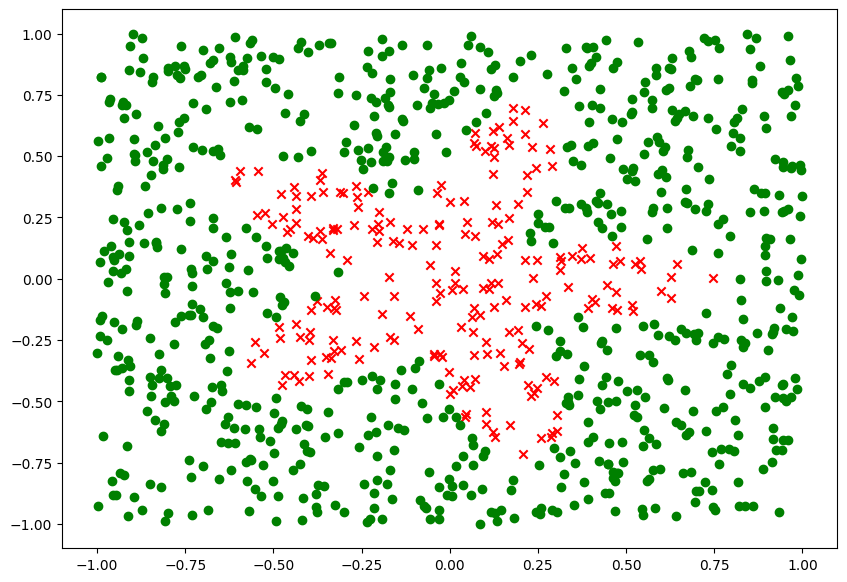

In [105]:
# Dataset parameters
np.random.seed(17)
min_val = -1
max_val = 1
n_points = 1000
# Load dataset from file
excel_file_path = 'dataset_new.xlsx'
val1_list, val2_list, inputs, outputs = load_dataset(excel_file_path = excel_file_path)
# Visualize data in arrays
print(inputs.shape, outputs.shape)
print("Number of samples with class 0:", len(outputs) - sum(outputs))
print("Number of samples with class 1:", sum(outputs))
# Visualize the dataset
plot_dataset(min_val, max_val, val1_list, val2_list, outputs)

The cell below also needs to be updated with your solution for de Dataloader part in Notebook 1-A.

In [106]:
# Create Dataset object
pt_dataset = CustomDataset()
# Define batch size
batch_size = 128
# Create DataLoader object
pt_dataloader = DataLoader(pt_dataset, batch_size, shuffle=True)

## 5. Defining a Neural Network for this task - Part1: Architecture and Forward Propagation

In this section, we will establish our Neural Network model for this task. The architecture will consist of:
- One WeirdOperation Layer (weird_layer), which takes 2 inputs and produces 32 outputs,
- First Linear Layer (hidden1): Takes 32 inputs and produces 64 outputs, followed by a GELU activation function.
- Second Linear Layer (hidden2): Takes 64 inputs and produces 32 outputs, followed by a GELU activation function.
- Third Linear Layer (hidden3): Takes 32 inputs and produces 16 outputs, followed by a GELU activation function.
- Final Linear Layer (fc): Takes 16 inputs and produces 1 output.
- Final Activation (sigmoid): Applies a Sigmoid activation to map the output, making it suitable for binary classification.

Our Neural Network will use Binary Cross-Entropy as a loss functions (to be stored in the self.loss attribute) and the binary accuracy from the torchmetrics library, stored in the self.accuracy attribute.

**Question 10:** Show your final code for the *NeuralNetwork* class in your report.

The code below, will describe our neural network model and a few None variables need to be replaced.

In [107]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.weird_layer = WeirdLayer(2, 32)
        self.hidden1 = nn.Linear(32, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.fc = nn.Linear(16, 1)
        self.activation = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()
        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        x = self.weird_layer(x)
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [108]:
# Create Neural Network model
model = NeuralNetwork()

**Question 11:** Why is the purpose of the Sigmoid activation used in the final layer? Why can't we simply use a Weird layer as the final operation in the forward method?

In [109]:
print(model)

NeuralNetwork(
  (weird_layer): WeirdLayer(
    (linear): Linear(in_features=2, out_features=32, bias=True)
    (fc_for_tanh): Linear(in_features=2, out_features=32, bias=True)
  )
  (hidden1): Linear(in_features=32, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
  (loss): BCELoss()
  (accuracy): BinaryAccuracy()
)


## 6. Defining a Neural Network for this task - Part2: BackPropagation and Training

Have a look at the code below. The code:
- Initializes our model.
- Initializes an Adam Optimizer, and asks for 15 iterations of the forward-backprop.
- For each mini-batch of data drawn on each iteration, it produces predictions, calculates a loss and calculates the binary accuracy on said samples.
- It then backpropagates on the *loss_value* and adjusts the model parameters using *optimizer.step()*.
- Finally, it shows a nice display.

**Question 12:** Why do we use nn.BCELoss() instead of nn.CrossEntropyLoss() for binary classification?

**ANSWER 12:**

For nn.CrossEntropy(), it requires two output neurons and applies softmax, which is redundant cause for binary classification we only need one probablity (i.e. p(class1) = 1 - p(class0)) and computing of nn.CrossEntropy() is not possible cause our current neural network class does not support the infrastructure required to implement nn.CrossEntropy().

Furthermore, nn.BCELoss() is more computationally efficient for binary classification as it only uses one output neuron.


In [110]:
# Create Neural Network model
model = NeuralNetwork().to(device)

# Gradient descent parameters: optimizers, repetitions, etc.
num_epochs = 15
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01,
                             betas = (0.9, 0.999),
                             eps = 1e-08)
optimizer.zero_grad()

for epoch in range(num_epochs):
    for batch in pt_dataloader:
        # Unpack the mini-batch data
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)

        # Forward pass
        pred = model(inputs_re)
        loss_value = model.loss(pred.float(), outputs_re.float())
        # Compute binary accuracy
        binary_accuracy_value = model.accuracy(pred, outputs_re)

        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Print loss and accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_value.item():.4f}, Training Accuracy: {binary_accuracy_value.item():.4f}')

Epoch [1/15], Training Loss: 0.5059, Training Accuracy: 0.7692
Epoch [2/15], Training Loss: 0.3606, Training Accuracy: 0.8173
Epoch [3/15], Training Loss: 0.2704, Training Accuracy: 0.8462
Epoch [4/15], Training Loss: 0.2242, Training Accuracy: 0.9231
Epoch [5/15], Training Loss: 0.1963, Training Accuracy: 0.9038
Epoch [6/15], Training Loss: 0.3795, Training Accuracy: 0.8269
Epoch [7/15], Training Loss: 0.3304, Training Accuracy: 0.8365
Epoch [8/15], Training Loss: 0.2384, Training Accuracy: 0.8462
Epoch [9/15], Training Loss: 0.2693, Training Accuracy: 0.8558
Epoch [10/15], Training Loss: 0.2266, Training Accuracy: 0.9038
Epoch [11/15], Training Loss: 0.2057, Training Accuracy: 0.8942
Epoch [12/15], Training Loss: 0.2199, Training Accuracy: 0.8750
Epoch [13/15], Training Loss: 0.1778, Training Accuracy: 0.9231
Epoch [14/15], Training Loss: 0.2053, Training Accuracy: 0.9038
Epoch [15/15], Training Loss: 0.1425, Training Accuracy: 0.9519


In [111]:
# Results on test set for implementing batch normalization
test_dataset = CustomDataset(filename='unseen_dataset_new.xlsx')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for inputs_batch, outputs_batch in test_dataloader:
    outputs_re = outputs_batch.to(device).reshape(-1, 1)
    inputs_re = inputs_batch.to(device)
    pred = model(inputs_re)
    loss_value = model.loss(pred.float(), outputs_re.float())
    binary_accuracy_value = model.accuracy(pred, outputs_re)

print(f'Test Loss: {loss_value.item():.4f}, Test Accuracy: {binary_accuracy_value.item():.4f}')

Test Loss: 0.1388, Test Accuracy: 0.9297


**Question 13:** When running the cell above, it seems the model is not capable of achieving a great accuracy. If anything, it seems to remain stuck at an accuracy of 30% or so. Did we make a mistake in one of our hyperparameters (e.g. the learning rate)? Or is the model simply incapable of figuring out this task (maybe because of the weird layer we have decided to use)?

**ANSWER 13:**


1.   Alpha Adjustment (alpha_init=1.2): The alpha parameter in the weird layer controls how much of the tanh transformation contributes to the final output. Given, the non-linearity of the data-spread, I hypothesise that maybe allowing the tanh componenet to have a stronger influence can potentially improve feature extraction.  
2.   Learning Rate Adjustment (lr = 0.01): The orignal learning rate of 1000 is too large and could have been leading to divergence, for e.g. the gradient updates with lr=1000 might have been so large that the model jumps past the optimal values and fails to learn. With lr=0.01, the optimizer makes gradual, controlled updates, potentially leading to better convergence.





**Question 14:** Assuming you figured out what was wrong in Question 13, show in your report how you resolved the problem in the code above.
Your model should be able to produce a final training accuracy above 90%.

**ANSWER 14:** Final Training Accuracy:  0.9519


**Question 15:** How can we improve the generalization ability of a model? Please list at least two methods and explain their principles.

**ANSWER 15:**

1. Implementing Batch Normalisation: The objective is to stabalize the distribution of activations within a neural network layer by calculating the mean and standard deviation of a mini-batch of data and then normalizing the activations using these statistics. 

2. Increasing Number of Epochs: With increased number of epochs, it allows for multiple passes over the dataset, this allows the model to learn better representations of the data by gradually refining its weight. Perhaps, the morel can move from simple patterns in the early layers to more complex relationships in deeper layers. 

**Question 16:** Having figured out how to prove/disprove generalization in Question 15, we leave the rest of the notebook cells for you to play with the code and figure out how to prove that your model is indeed capable of generalization (or not). Show your code, your results and how it matches the reasoning you described in Question 16. Is your model truly capable of solving this classification task in the end?

**ANSWER 16:**

1. Based on my results, implementing batch normalisation does not allow the model to generalise better. As seen by the drop in accuracy of the model in predicting the unseen dataset from 0.9297 for the orignal model to 0.8828 for the normalisation modified model. 

2. Based on my results, implementing increasing the number of epochs does allow the model to generalise better. As seen by the increase in accuracy of the model in predicting the unseen dataset from 0.9297 for the orignal model to 0.9531 for the epoch modified model. 

Workings can be found in code cells with the comment "#WORKING FOR QUESTION 15/16".

**Question 17:** Looking back at the dataset and the samples distribution, do you feel *feature engineering* could have been useful here? If so, which synthetic features would you craft for this dataset? Bonus points might be given if you show code demonstrating some feature engineering.

**ANSWER 17:**

I created 4 new features: 'x1_x2_sum', 'x1_x2_product', 'x1_squared', 'x2_squared'. 

But I did not know which feature combination would work best, so I thought to conduct a experiment for the different iterations. Based on my results from experiment 1, the best performing combination was (x1, x2, x1_x2_sum, x1_x2_product, x2_squared) with an accuracy score of 0.971154. 

But then I thought, how can I make this model better, so I thought maybe this model is underfitting and want to increase the model complexity. Hence, in my experiment 2, I increase the number of features and also respectively scale my number of neurons in each layer. Based on my results from experiment 2, the best performing combination was (x1, x2, x1_x2_sum, x1_x2_product) with an accuracy score of 0.990385. The best performance in this notebook. 

Workings can be found in code cells with the comment "#WORKING FOR QUESTION 17 - EXPERIMENT 1" and #WORKING FOR QUESTION 17 - EXPERIMENT 2.

In [112]:
#WORKING FOR QUESTION 15/16

# implementing batch normalization
class NeuralNetwork_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.weird_layer = WeirdLayer(2, 32)  
        self.hidden1 = nn.Linear(32, 64)
        self.bn1 = nn.BatchNorm1d(64)  
        self.hidden2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)  
        self.hidden3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc = nn.Linear(16, 1)
        
        self.activation = nn.GELU()
        self.sigmoid = nn.Sigmoid()

        # Loss function and metric
        self.loss = nn.BCELoss()
        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        x = self.weird_layer(x)
        x = self.hidden1(x)
        x = self.bn1(x)  
        x = self.activation(x)
        
        x = self.hidden2(x)
        x = self.bn2(x)
        x = self.activation(x)
        
        x = self.hidden3(x)
        x = self.bn3(x)
        x = self.activation(x)
        
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Create Neural Network model
model_v2 = NeuralNetwork_v2().to(device)

# Gradient descent parameters: optimizers, repetitions, etc.
num_epochs = 15
optimizer = torch.optim.Adam(model_v2.parameters(),
                             lr = 0.01,
                             betas = (0.9, 0.999),
                             eps = 1e-08)
optimizer.zero_grad()

for epoch in range(num_epochs):
    for batch in pt_dataloader:
        # Unpack the mini-batch data
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)

        # Forward pass
        pred = model_v2(inputs_re)
        loss_value = model.loss(pred.float(), outputs_re.float())
        # Compute binary accuracy
        binary_accuracy_value = model_v2.accuracy(pred, outputs_re)

        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Print loss and accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_value.item():.4f}, Training Accuracy: {binary_accuracy_value.item():.4f}')

Epoch [1/15], Training Loss: 0.3719, Training Accuracy: 0.8365
Epoch [2/15], Training Loss: 0.2433, Training Accuracy: 0.9327
Epoch [3/15], Training Loss: 0.2821, Training Accuracy: 0.8462
Epoch [4/15], Training Loss: 0.2815, Training Accuracy: 0.8750
Epoch [5/15], Training Loss: 0.2473, Training Accuracy: 0.8942
Epoch [6/15], Training Loss: 0.2351, Training Accuracy: 0.8846
Epoch [7/15], Training Loss: 0.2158, Training Accuracy: 0.9231
Epoch [8/15], Training Loss: 0.2187, Training Accuracy: 0.8942
Epoch [9/15], Training Loss: 0.2666, Training Accuracy: 0.8365
Epoch [10/15], Training Loss: 0.2536, Training Accuracy: 0.8654
Epoch [11/15], Training Loss: 0.5348, Training Accuracy: 0.8173
Epoch [12/15], Training Loss: 0.2684, Training Accuracy: 0.8654
Epoch [13/15], Training Loss: 0.2298, Training Accuracy: 0.8750
Epoch [14/15], Training Loss: 0.2162, Training Accuracy: 0.8750
Epoch [15/15], Training Loss: 0.1976, Training Accuracy: 0.9038


In [113]:
#WORKING FOR QUESTION 15/16

# Results on test set for implementing batch normalization
test_dataset = CustomDataset(filename='unseen_dataset_new.xlsx')
pt_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for inputs_batch, outputs_batch in pt_dataloader:
    outputs_re = outputs_batch.to(device).reshape(-1, 1)
    inputs_re = inputs_batch.to(device)
    pred = model_v2(inputs_re)
    loss_value = model_v2.loss(pred.float(), outputs_re.float())
    binary_accuracy_value = model_v2.accuracy(pred, outputs_re)

print(f'Test Loss: {loss_value.item():.4f}, Test Accuracy: {binary_accuracy_value.item():.4f}')

Test Loss: 0.2290, Test Accuracy: 0.8828


In [114]:
#WORKING FOR QUESTION 15/16

# increasing the number of epochs

# Create Neural Network model
model_v3 = NeuralNetwork_v2().to(device)

# Gradient descent parameters: optimizers, repetitions, etc.
num_epochs = 50
optimizer = torch.optim.Adam(model_v3.parameters(),
                             lr = 0.01,
                             betas = (0.9, 0.999),
                             eps = 1e-08)
optimizer.zero_grad()

for epoch in range(num_epochs):
    for batch in pt_dataloader:
        # Unpack the mini-batch data
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)

        # Forward pass
        pred = model_v3(inputs_re)
        loss_value = model.loss(pred.float(), outputs_re.float())
        # Compute binary accuracy
        binary_accuracy_value = model_v3.accuracy(pred, outputs_re)

        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Print loss and accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_value.item():.4f}, Training Accuracy: {binary_accuracy_value.item():.4f}')

Epoch [1/50], Training Loss: 0.5812, Training Accuracy: 0.6875
Epoch [2/50], Training Loss: 0.4996, Training Accuracy: 0.9062
Epoch [3/50], Training Loss: 0.4711, Training Accuracy: 0.9141
Epoch [4/50], Training Loss: 0.4314, Training Accuracy: 0.9141
Epoch [5/50], Training Loss: 0.4072, Training Accuracy: 0.9141
Epoch [6/50], Training Loss: 0.3873, Training Accuracy: 0.9141
Epoch [7/50], Training Loss: 0.3677, Training Accuracy: 0.9141
Epoch [8/50], Training Loss: 0.3490, Training Accuracy: 0.9141
Epoch [9/50], Training Loss: 0.3305, Training Accuracy: 0.9062
Epoch [10/50], Training Loss: 0.3128, Training Accuracy: 0.9141
Epoch [11/50], Training Loss: 0.2967, Training Accuracy: 0.9141
Epoch [12/50], Training Loss: 0.2825, Training Accuracy: 0.9141
Epoch [13/50], Training Loss: 0.2695, Training Accuracy: 0.9141
Epoch [14/50], Training Loss: 0.2573, Training Accuracy: 0.9141
Epoch [15/50], Training Loss: 0.2460, Training Accuracy: 0.9141
Epoch [16/50], Training Loss: 0.2352, Training Ac

In [115]:
#WORKING FOR QUESTION 15/16
# Results on test set for implementing batch normalization
test_dataset = CustomDataset(filename='unseen_dataset_new.xlsx')
pt_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for inputs_batch, outputs_batch in pt_dataloader:
    outputs_re = outputs_batch.to(device).reshape(-1, 1)
    inputs_re = inputs_batch.to(device)
    pred = model_v3(inputs_re)
    loss_value = model_v3.loss(pred.float(), outputs_re.float())
    binary_accuracy_value = model_v3.accuracy(pred, outputs_re)

print(f'Test Loss: {loss_value.item():.4f}, Test Accuracy: {binary_accuracy_value.item():.4f}')

Test Loss: 0.1104, Test Accuracy: 0.9531


In [ ]:
#WORKING FOR QUESTION 17 - EXPERIMENT 1
from itertools import combinations

# Define dataset with feature selection
class CustomDataset_FE(Dataset):
    def __init__(self, filename='dataset_new.xlsx', feature_indices=None):
        self.dataframe = pd.read_excel(filename)
        self.feature_indices = feature_indices
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        x1 = self.dataframe.iloc[idx, 0]
        x2 = self.dataframe.iloc[idx, 1]
        y = self.dataframe.iloc[idx, 2]

        x1_x2_sum = x1 + x2
        x1_x2_product = x1 * x2
        x1_squared = x1 ** 2
        x2_squared = x2 ** 2

        all_features = [x1, x2, x1_x2_sum, x1_x2_product, x1_squared, x2_squared]
        selected_features = [torch.tensor(all_features[i], dtype=torch.float32) for i in self.feature_indices]
        inputs = torch.stack(selected_features)
        y = torch.tensor(y, dtype=torch.float32)

        return inputs, y

# Define Neural Network
class NeuralNetwork_FE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.weird_layer = WeirdLayer(input_size, 32)
        self.hidden1 = nn.Linear(32, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.fc = nn.Linear(16, 1)
        self.activation = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()
        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        x = self.weird_layer(x)  
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Training function
def train_and_evaluate(feature_indices):
    dataset = CustomDataset_FE(feature_indices=feature_indices)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = NeuralNetwork_FE(len(feature_indices)).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01,
                             betas = (0.9, 0.999),
                             eps = 1e-08)
    optimizer.zero_grad()
    epochs = 15
    
    for epoch in range(epochs):
        for batch in dataloader:
            inputs_batch, outputs_batch = batch
            inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device).reshape(-1, 1)
            
            pred = model(inputs_batch)
            loss_value = model.loss(pred.float(), outputs_batch.float())
            binary_accuracy_value = model.accuracy(pred, outputs_batch)
            
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    return binary_accuracy_value.item()

# Test different feature combinations
feature_names = ['x1', 'x2', 'x1_x2_sum', 'x1_x2_product', 'x1_squared', 'x2_squared']
results = []

for num_features in range(2, 6):
    for feature_comb in combinations(range(6), num_features):
        accuracy = train_and_evaluate(feature_comb)
        results.append((feature_comb, accuracy))


results.sort(key=lambda x: x[1], reverse=True)


results_df = pd.DataFrame([(tuple(feature_names[i] for i in comb), acc) for comb, acc in results], columns=["Feature Combination", "Accuracy"])
print(results_df)

results_df.to_excel('results_experiment_1.xlsx', index=False)


                                  Feature Combination  Accuracy
0      (x1, x2, x1_x2_sum, x1_x2_product, x2_squared)  0.971154
1              (x1_x2_sum, x1_x2_product, x1_squared)  0.942308
2                     (x1, x2, x1_x2_sum, x1_squared)  0.942308
3                                 (x1, x2, x1_x2_sum)  0.932692
4                             (x1, x2, x1_x2_product)  0.932692
5                                (x1, x2, x2_squared)  0.932692
6                        (x2, x1_squared, x2_squared)  0.932692
7          (x2, x1_x2_sum, x1_x2_product, x1_squared)  0.932692
8      (x1, x2, x1_x2_sum, x1_x2_product, x1_squared)  0.932692
9                                     (x1, x1_x2_sum)  0.923077
10                     (x1, x1_x2_sum, x1_x2_product)  0.923077
11                        (x1, x1_x2_sum, x1_squared)  0.923077
12                    (x1, x2, x1_x2_sum, x2_squared)  0.923077
13                (x1, x2, x1_x2_product, x1_squared)  0.923077
14                (x1, x2, x1_x2_product

In [ ]:
#WORKING FOR QUESTION 17 - EXPERIMENT 2
from itertools import combinations

# Define dataset with feature selection
class CustomDataset_FE(Dataset):
    def __init__(self, filename='dataset_new.xlsx', feature_indices=None):
        self.dataframe = pd.read_excel(filename)
        self.feature_indices = feature_indices
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        x1 = self.dataframe.iloc[idx, 0]
        x2 = self.dataframe.iloc[idx, 1]
        y = self.dataframe.iloc[idx, 2]

        x1_x2_sum = x1 + x2
        x1_x2_product = x1 * x2
        x1_squared = x1 ** 2
        x2_squared = x2 ** 2

        all_features = [x1, x2, x1_x2_sum, x1_x2_product, x1_squared, x2_squared]
        selected_features = [torch.tensor(all_features[i], dtype=torch.float32) for i in self.feature_indices]
        inputs = torch.stack(selected_features)
        y = torch.tensor(y, dtype=torch.float32)

        return inputs, y

# Define Neural Network
class NeuralNetwork_FE(nn.Module):
    def __init__(self, input_size, scale_factor=1):
        super().__init__()

        # Calculate sizes based on scale factor while maintaining ratios
        h1_size = int(32 * scale_factor)
        h2_size = int(64 * scale_factor)
        h3_size = int(32 * scale_factor)
        h4_size = int(16 * scale_factor)
        
        self.weird_layer = WeirdLayer(input_size, h1_size) 
        self.hidden1 = nn.Linear(h1_size, h2_size)  
        self.hidden2 = nn.Linear(h2_size, h3_size)  
        self.hidden3 = nn.Linear(h3_size, h4_size)  
        self.fc = nn.Linear(h4_size, 1)
        self.activation = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCELoss()
        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        x = self.weird_layer(x)  
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Training function
def train_and_evaluate(feature_indices, scale_factor):
    dataset = CustomDataset_FE(feature_indices=feature_indices)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = NeuralNetwork_FE(len(feature_indices), scale_factor).to(device)
    optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01,
                             betas = (0.9, 0.999),
                             eps = 1e-08)
    optimizer.zero_grad()
    epochs = 15
    
    for epoch in range(epochs):
        for batch in dataloader:
            inputs_batch, outputs_batch = batch
            inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device).reshape(-1, 1)
            
            pred = model(inputs_batch)
            loss_value = model.loss(pred.float(), outputs_batch.float())
            binary_accuracy_value = model.accuracy(pred, outputs_batch)
            
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    return binary_accuracy_value.item()

# Test different feature combinations
feature_names = ['x1', 'x2', 'x1_x2_sum', 'x1_x2_product', 'x1_squared', 'x2_squared']
results = []

for num_features in range(2, 6):
    for feature_comb in combinations(range(6), num_features):
        accuracy = train_and_evaluate(feature_comb, num_features//2)
        results.append((feature_comb, accuracy))


results.sort(key=lambda x: x[1], reverse=True)


results_df = pd.DataFrame([(tuple(feature_names[i] for i in comb), acc) for comb, acc in results], columns=["Feature Combination", "Accuracy"])
print(results_df)

results_df.to_excel('results_experiment_2.xlsx', index=False)


                                  Feature Combination  Accuracy
0                  (x1, x2, x1_x2_sum, x1_x2_product)  0.990385
1                                 (x1, x2, x1_x2_sum)  0.971154
2          (x2, x1_x2_sum, x1_x2_product, x1_squared)  0.971154
3      (x1, x2, x1_x2_sum, x1_x2_product, x2_squared)  0.971154
4                     (x1, x2, x1_x2_sum, x2_squared)  0.961538
5          (x2, x1_x2_sum, x1_x2_product, x2_squared)  0.961538
6                         (x2, x1_x2_sum, x1_squared)  0.951923
7          (x1, x1_x2_sum, x1_x2_product, x2_squared)  0.951923
8                                     (x2, x1_x2_sum)  0.942308
9                 (x1, x2, x1_x2_product, x1_squared)  0.942308
10                (x1, x2, x1_x2_product, x2_squared)  0.942308
11  (x2, x1_x2_sum, x1_x2_product, x1_squared, x2_...  0.942308
12                        (x2, x1_x2_sum, x2_squared)  0.932692
13                    (x1, x2, x1_x2_sum, x1_squared)  0.932692
14                     (x1, x1_x2_sum, x